In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import torch

In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Code")
from eeg_project_package import dataset, models, training

In [3]:
import importlib
importlib.reload(dataset)
importlib.reload(training)

<module 'eeg_project_package.training' from '/home/aurelien.stumpf/Code/eeg_project_package/training.py'>

Extracting EDF parameters from /home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Number of channels:  64
Number of samples:  64
Using matplotlib as 2D backend.


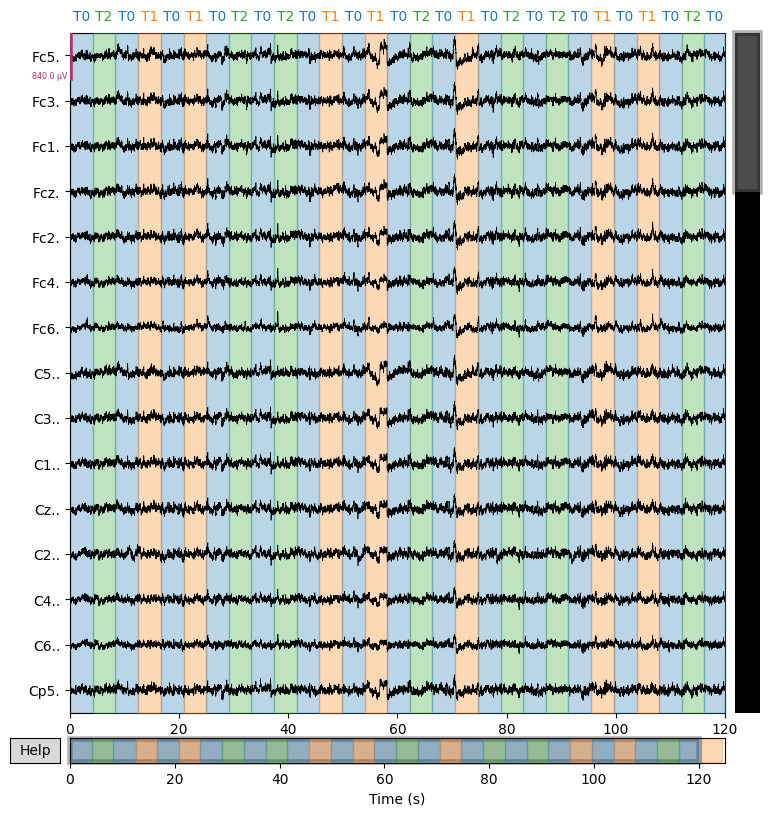

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


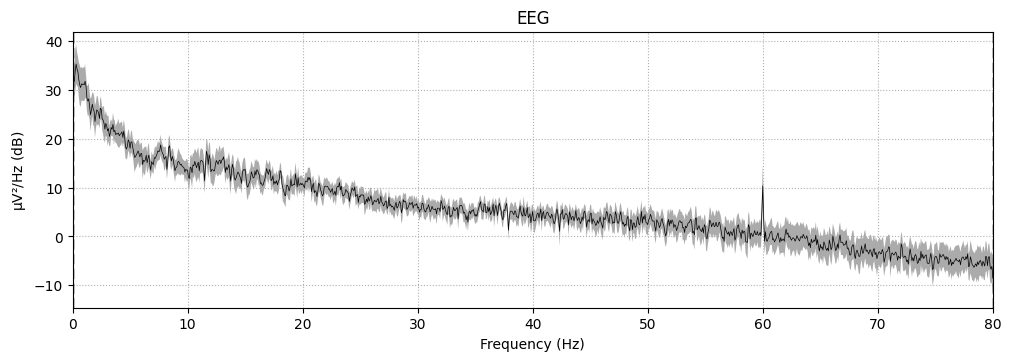

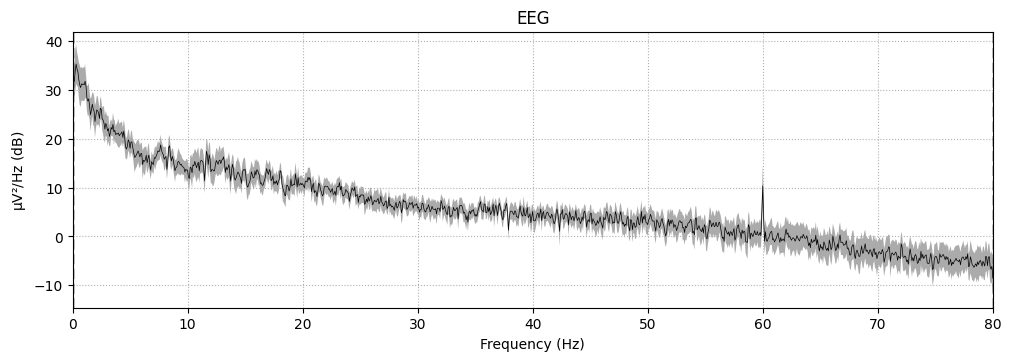

In [4]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/home/aurelien.stumpf/Code/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf"
input_fname2 =  "/home/aurelien.stumpf/Code/physionet.org/files/eegmmidb/1.0.0/S001/S001R02.edf"
input_fname3 =  "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname3, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

In [5]:
total_events,dict_ = mne.events_from_annotations(raw_obj)
print(total_events[:,2])

Used Annotations descriptions: ['T0', 'T1', 'T2']
[1 3 1 2 1 2 1 3 1 3 1 2 1 2 1 3 1 2 1 3 1 3 1 2 1 2 1 3 1 2]


In [27]:
list_name_channels = ["Cp1.","Cp3.","Cp5.","C1..","C3..","C5..","C2..","Cp2.","Cz..","Fcz.","C4..","Cp4."]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

task_type = "imaginary_left/right"
folder_path = "/home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/"

if task_type == "imaginary_feet/hand":
    num_sessions = [5, 6, 9, 10, 13, 14]
    num_train_subjects = list(range(1, 50))
    num_test_subjects = list(range(50, 70))
elif task_type == "imaginary_left/right":
    num_sessions = [4, 8, 12]
    num_train_subjects = list(range(1, 50))
    num_test_subjects = list(range(50, 70))

numpy_trainset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, type_ = "numpy")
numpy_testset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, type_ = "numpy")

torch_trainset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, type_ = "torch")
torch_testset = dataset.EEG_PSD_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, type_ = "torch")
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=32, shuffle=True, num_workers=2)

Extracting EDF parameters from /home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /home/aurelien.stumpf/Code/datasets/eeg_data/physionet.org/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from /home/aur

In [28]:
X_train = numpy_trainset.features.reshape(numpy_trainset.features.shape[0], -1)
y_train = numpy_trainset.labels
X_test = numpy_testset.features.reshape(numpy_testset.features.shape[0], -1)
y_test = numpy_testset.labels

# Train LDA classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA Accuracy: ", acc)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM Accuracy: ", acc)

# Train XGBoost classifier
bst = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.0005, objective='binary:logistic')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
acc = np.mean(preds == y_test)
print("XGBoost Accuracy: ", acc)

LDA Accuracy:  0.5095238095238095
SVM Accuracy:  0.4880952380952381
XGBoost Accuracy:  0.4976190476190476
